In [1]:
from __future__ import print_function
import os
import sys
import time

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import json

import adjustable_upscaleNst
import imp
imp.reload(adjustable_upscaleNst)
from adjustable_upscaleNst import AdjustableNetwork
import adaptiveStroke
imp.reload(adaptiveStroke)
from adaptiveStrokeNet import JohnsonAdaptiveStroke
import gc



from myutils import utils
imp.reload(utils)
from myutils.utils import closestNumber, get_files_sorted, construct_modelpath


from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib

%matplotlib notebook
#%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,14)

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, SelectionSlider, Dropdown


def remove_IN_params(state_dict):
    new_dict = {}
    for (k,v) in state_dict.items():
        if not ".in1." in k:
            new_dict[k] = state_dict[k]
    return new_dict
            

In [2]:
%%javascript
// run all cells on press of ctrl+m then r
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

torch.Size([1, 3, 192, 256])


<IPython.core.display.Javascript object>


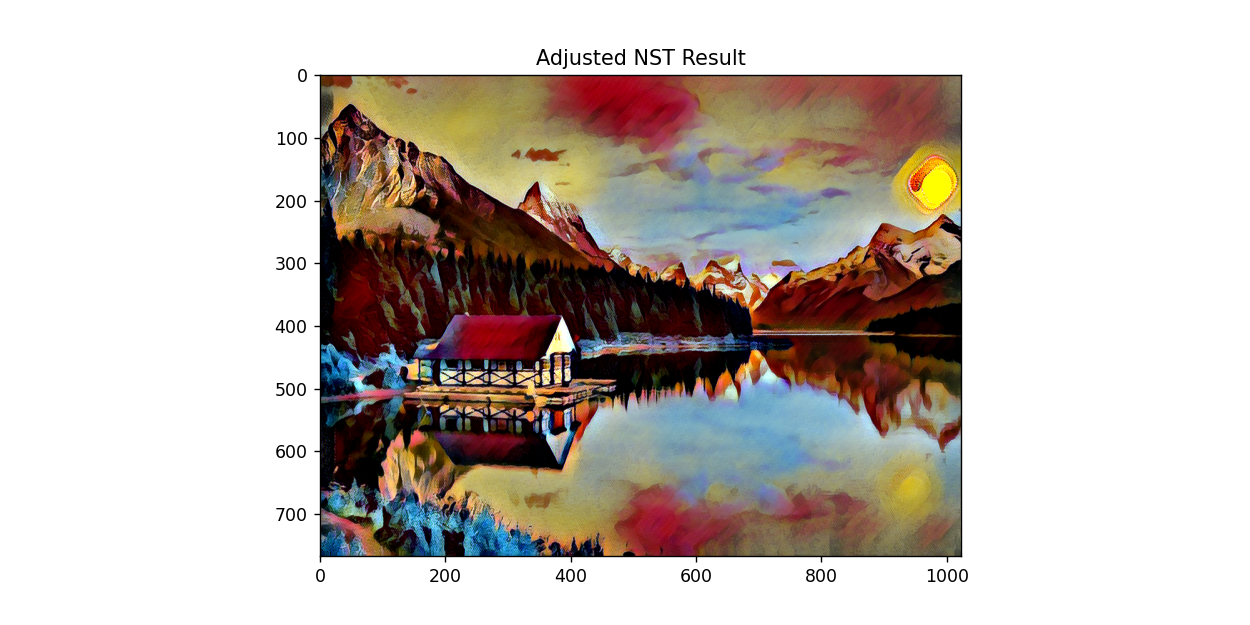

interactive(children=(FloatSlider(value=0.33, description='intensity', max=1.0, step=0.05), SelectionSlider(de…

In [6]:
torch.cuda.empty_cache()
content_size = 1024
content_path = module_path + "/images/content/canada_lake.jpg"
content_name = os.path.splitext(os.path.basename(content_path))[0]

upscale_fact = 4

dgf_type = "guidedConv"
alt_dgf_type = "guidedMapConv"
module_subdir = "models/guided_models/archsearch"

device = torch.device("cuda") 
content_image = utils.tensor_load_rgbimage(content_path, size=int(content_size/upscale_fact), keep_asp=True)#.half()
content_image = content_image.unsqueeze(0).to(device)
content_image = utils.preprocess_batch(content_image)

print(content_image.size())
unscaled_dim = content_image.shape[-2]
scaled_dim = closestNumber(unscaled_dim, 4)
# scale other dimension to closest number dividable by 4 to avoid dimension differences between branches
content_image = F.interpolate(content_image, size=(scaled_dim, content_image.shape[-1]), 
                              mode="bilinear",align_corners=True)

content_image_hr = utils.tensor_load_rgbimage(content_path, size=content_size, keep_asp=False)#.half()
content_image_hr = content_image_hr.unsqueeze(0).to(device)
content_image_hr = utils.preprocess_batch(content_image_hr)
content_image_hr = F.interpolate(content_image_hr, size=(scaled_dim*upscale_fact, content_image_hr.shape[-1]), 
                              mode="bilinear",align_corners=False)


def load_model(model, model_path):
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    model.to(device)
    model.eval()
    return model

def set_argument(model_path):
    json_path =  model_path.split(".")[0].replace("epoch", "train_config_epoch") + ".json"
    if os.path.exists(json_path):
        with open(json_path,"r") as fd:
            lines = fd.readlines()
            for line in lines:
                if "pixel_kern_size" in line:
                    num = int(line.strip().split(":")[-1].replace(",", ""))
                    adjustable_upscaleNst.args.pixel_kern_size = num
            #    variables = json.load(fd)
            # for key, item in variables.items():
            #     if key in dir(args):
            #         setattr(args, key, item)
    else:
        print('doesnt exist:', json_path)

def set_args(model_path):
    json_path = model_path


def load_guided_map_conv(style_dirname):
    model_path = construct_modelpath(module_path, module_subdir, "guidedConv", style_dirname)
    set_argument(model_path)
    return load_model(AdjustableNetwork(dgf_type="guidedConv"), model_path) 

def load_guided_conv(style_dirname):
    model_path = construct_modelpath(module_path, module_subdir, "guidedMapConv", style_dirname)
    set_argument(model_path)
    return load_model(AdjustableNetwork(dgf_type="guidedMapConv"), model_path) 

def load_guided_conv_reversed(style_dirname):
    model_path = construct_modelpath(module_path, module_subdir, "guidedConvReversed", style_dirname)
    set_argument(model_path)
    return load_model(AdjustableNetwork(dgf_type="guidedConvReversed"), model_path) 

def load_guided_map_conv_reversed(style_dirname):
    model_path = construct_modelpath(module_path, module_subdir, "guidedMapConvReversed", style_dirname)
    set_argument(model_path)
    return load_model(AdjustableNetwork(dgf_type="guidedMapConvReversed"), model_path) 

def load_standard(*args):
    standard_model_dir = module_path + "/models/guided_models/"
    standard_model_name = "delaunay_standard_adjustable/delaunay.model"
    standard_model_path = standard_model_dir + standard_model_name
    set_argument(standard_model_path)
    standard_style_model = AdjustableNetwork(dgf_type=None, fusion_krnsize=9)
    model_weights = torch.load(standard_model_path)
    standard_style_model.load_state_dict(remove_IN_params(model_weights))
    standard_style_model.to(device)
    standard_style_model.eval()
    return standard_style_model

def load_pac(*args):
    pac_model_dir = module_path + "/models/guided_models/starry_night_PAC/"
    pac_model_name = "epoch.model"
    pac_model_path = pac_model_dir + pac_model_name
    set_argument(pac_model_path)
    return load_model(AdjustableNetwork(dgf_type="PAC"), pac_model_path)

# def load_sr(*args):
#     sr_model_dir = module_path + "/models/guided_models/starry_night_SR_noguide_multires_v2/"
#     sr_model_name = "ckpt_epoch_1_iter_30000Wed_Dec_18_09:12:20_2019.pth"#"ckpt_epoch_1_iter_110000Tue_Dec_17_14:14:00_2019.pth"
    
#     sr_model_path = sr_model_dir + sr_model_name
#     set_argument(sr_model_path)
#     return load_model(AdjustableNetwork(sr_upsampling=True, max_upscale=4), sr_model_path)


def torch2img(tensor):
    np_tensor = tensor.float().cpu().squeeze(0).detach().clamp(0, 255).numpy()
    img = np_tensor.transpose(1, 2, 0).astype('uint8')
    return img[:,:,::-1] 

load_guided_conv_reversed("candy")
#with torch.no_grad():
#    test_out = torch2img(style_model(content_image, content_image_hr, torch.Tensor([1.0]).to(device), -1))
    
fig, ax = plt.subplots(figsize=(10, 5))
test_out = np.zeros(list(content_image_hr.size()[-2:]) + [3,]).astype('uint8')
im = ax.imshow(test_out, animated=True)
title = 'Adjusted NST Result'
plt.title(title)
fig.show()


previous = {"dgf": "", "model": None, "style":""}
dgf_load_funcs = {
    "guidedConv": load_guided_conv,
    "guidedMapConv": load_guided_map_conv,
    "guidedConvReversed": load_guided_conv_reversed,
    "guidedMapConvReversed": load_guided_map_conv_reversed,
    "standard": load_standard,
    "PAC": load_pac,
    # "SR": load_sr
}


def view_image(intensity, scale, noise_seed, dgf_input_type, style, add_unguided, im, fig):
    style_weights = torch.Tensor([intensity]).to(device)
    content_image_scaled = F.interpolate(content_image_hr, scale_factor=1.0/scale, mode="bilinear",align_corners=True)
    
    if previous["dgf"] != dgf_input_type or previous["style"] != style:
        previous["model"] = None; gc.collect(); torch.cuda.empty_cache()
        previous["model"] = dgf_load_funcs[dgf_input_type](style)
    model =  previous["model"]
            
    with torch.no_grad():
        output = model.forward(content_image_scaled, content_image_hr,  
                               style_weights, noise_seed)#, add_unguided_factor=add_unguided)
    
    img = torch2img(output)
    im.set_data(img)
    previous["dgf"] = dgf_input_type
    out_image = Image.fromarray(img)
    out_image.save(module_path + f"/images/output/guided_conf_map_reverse{scale}.jpg")
    plt.savefig("out")
    previous["dgf"] = dgf_input_type
    previous["model"] = model
    
slider_vals = [1.0, 2.0] 
styles = ["wave", "candy", "starry_night"] #supported dgf styles
slider_vals = utils.get_slider_vals(content_image_hr.size()[-1],content_image_hr.size()[-2], 40, upscale_fact)
slider_vals=[1.0, 1.03125, 1.0625, 1.09375, 1.125, 1.15625, 1.1875, 1.21875, 1.25, 1.28125, 1.3125, 1.34375, 1.375, 1.40625, 1.4375, 1.46875, 1.5, 1.53125, 1.5625, 1.59375, 1.625, 1.65625, 1.6875, 1.71875, 1.75, 1.78125, 1.8125, 1.84375, 1.875, 1.90625, 1.9375, 1.96875, 2.0]
interactive(view_image, intensity=FloatSlider(min=0,max=1.0,value=0.33,step=0.05), 
            scale=SelectionSlider(options=slider_vals, value=slider_vals[10]),
            noise_seed=-1,#IntSlider(min=1,max=100,value=1),
            dgf_input_type=Dropdown(options=dgf_load_funcs.keys(), value='guidedConvReversed', description='Guided Conv Type:'),
            style=Dropdown(options=styles, value='candy', description='Style:'),
            add_unguided = FloatSlider(min=0,max=1.0,value=0.5,step=0.05),
            im=fixed(im), fig=fixed(fig), continuous_update=True)


<IPython.core.display.Javascript object>


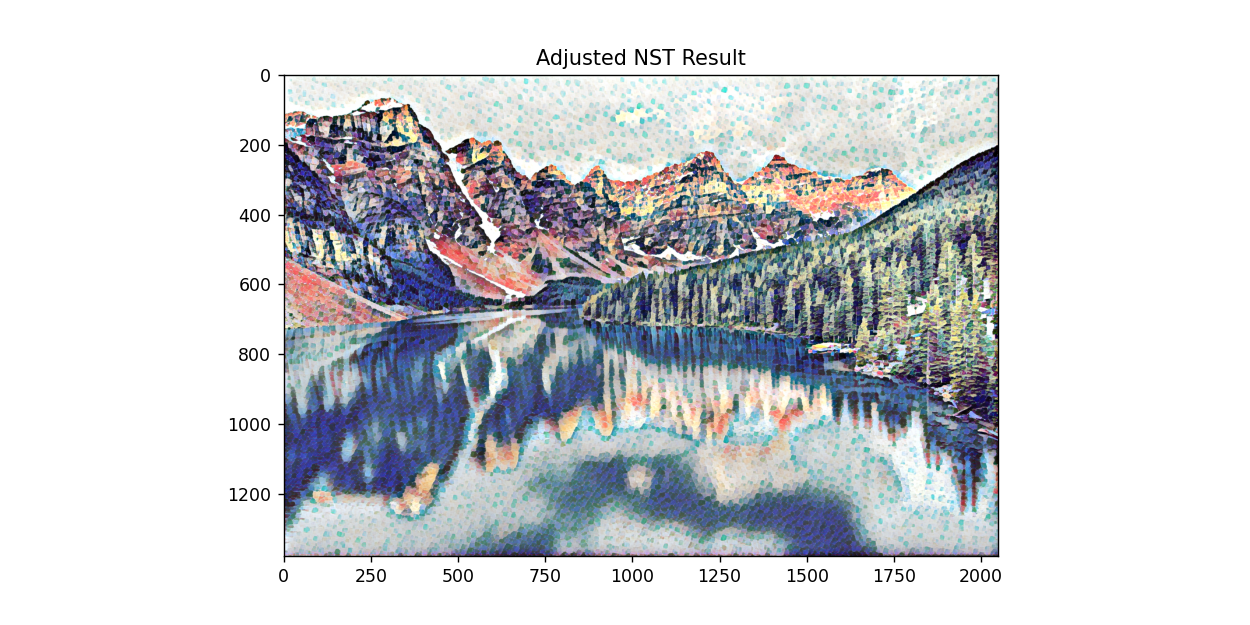

interactive(children=(FloatSlider(value=1.0, description='factor', max=2.0, step=0.03), Output()), _dom_classe…

In [3]:
#### Adaptive Stroke ####
content_size = 2048
content_path = module_path + "/images/content/canada_lake.jpg"
content_name = os.path.splitext(os.path.basename(content_path))[0]

model_dir =  module_path + "/models/adaptiveStroke/delaunay/"
model_name = "delaunay.model"
model_path = model_dir + model_name

device = torch.device("cuda") 
content_image = utils.tensor_load_rgbimage(content_path, size=content_size, keep_asp=True)
content_image = content_image.unsqueeze(0).to(device)
content_image = utils.preprocess_batch(content_image)

style_model = JohnsonAdaptiveStroke()
style_model.load_state_dict(torch.load(model_path))
style_model.to(device)
style_model.eval()

stroke_factor = 0.0


def torch2img(tensor, isbgr=True):
    np_tensor = tensor.float().cpu().squeeze(0).detach().clamp(0, 255).numpy()
    img = np_tensor.transpose(1, 2, 0).astype('uint8')
    return img[:,:,::-1]

def calculate_factors(stroke_factor):
    if stroke_factor <= 1.0:
        gamma = 0.0
        alpha = max(0.0, 1.0 - stroke_factor)
        beta = 1.0 - abs(stroke_factor - 1.0)
    else:
        stroke_factor -= 1
        alpha = 0.0
        beta = max(0.0, 1.0 - stroke_factor)
        gamma = 1.0 - abs(stroke_factor - 1.0)
        
    return torch.FloatTensor((alpha,)).to(device), torch.FloatTensor((beta,)).to(device), torch.FloatTensor((gamma,)).to(device)


with torch.no_grad():
    test_out = torch2img(style_model(content_image, stroke_factor))
    
    
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(test_out, animated=True)
title = 'Adjusted NST Result'
plt.title(title)
fig.show()



def view_image(factor, im, fig):#,c2,c3,c4):
    t0 = time.time()

    #print("scaled size: ", content_image_scaled.size())
    output = style_model(content_image, factor)
    t1 = time.time()
    img = torch2img(output)
    t2 = time.time()
    
    im.set_data(img)
    fig.canvas.draw()
    plt.savefig("out")
    
    output_image = Image.fromarray(img)
    output_image.save(module_path + f"/images/output/stroke_size_comparison/adaptive_{factor}.jpg")
    
    
    t3 = time.time()

    print("times prediction: {}s, to_img: {}s, plot: {}s".format(t1-t0,t2-t1,t3-t2))
        
interactive(view_image, factor=FloatSlider(min=0,max=2.0,value=1.0,step=0.03), 
            im=fixed(im), fig=fixed(fig), continuous_update=False)#
